In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

## define function for I(Q)

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

In [3]:
def p_debye(Q,Rg):
    QRg = Q*Rg
    u = QRg**2
    p = 2*(np.exp(-u)+u-1)/(u**2)
    p[QRg==0] = 1
    return p

## evaluate probability density on 2D detector

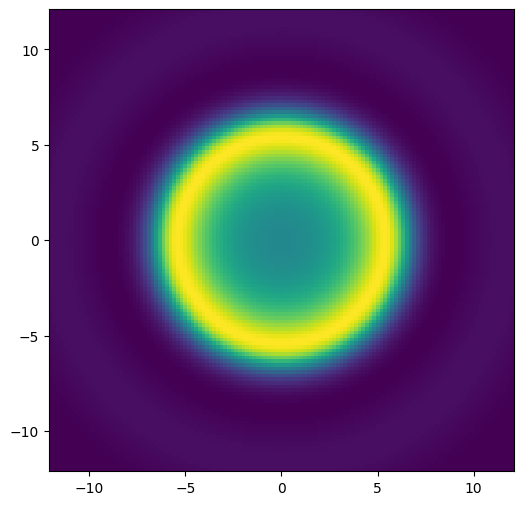

In [102]:
q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 0.01

p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, p_qxy, cmap='viridis')

## random sampling the scattering intensity

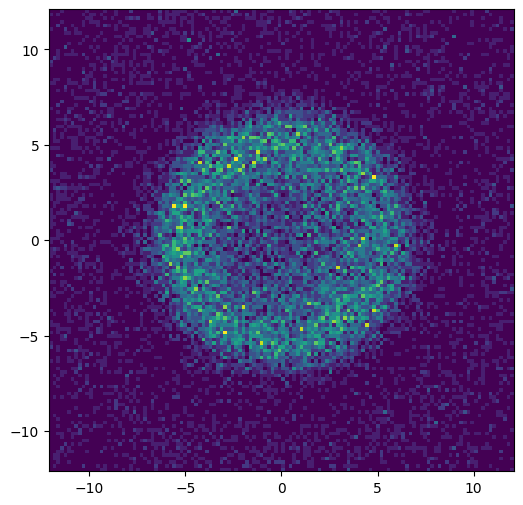

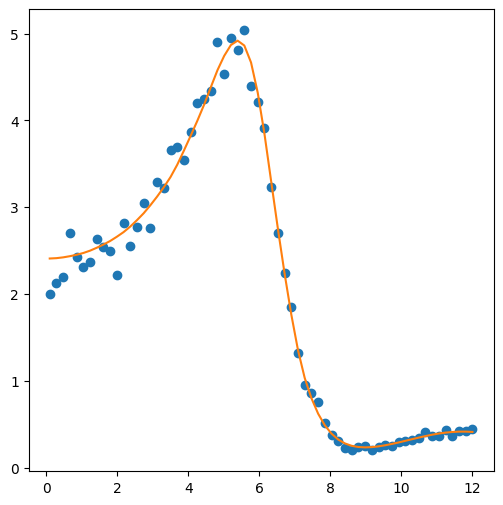

In [103]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]

n_sample = 20000  # specify the number of samples

n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

# Flatten the arrays
qx_flat = qx.flatten()
qy_flat = qy.flatten()
p_qxy_flat = p_qxy.flatten()

# Normalize the probability density
p_qxy_flat /= p_qxy_flat.sum()

# Randomly choose indices based on the probability density
indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

# Get the sampled qx and qy values
qx_samples = qx_flat[indices]
qy_samples = qy_flat[indices]

# evaluate the sampled point density in each grid

I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

# evaluate the radial averaged density
q = q_grid[q_grid > 0]
I_q = np.zeros_like(q)
I_q_th = np.zeros_like(q)
for i in range(len(q)):
    mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
    I_q[i] = I_q_grid[mask].mean()
    I_q_th[i] = p_qxy[mask].mean()

# Plot the sampled point density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis')

# Plot the radial averaged density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(q, I_q, 'o')

ax.plot(q, I_q_th*n_sample, '-')

In [104]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy):
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    I_q_th = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

## handle with noise by GPR

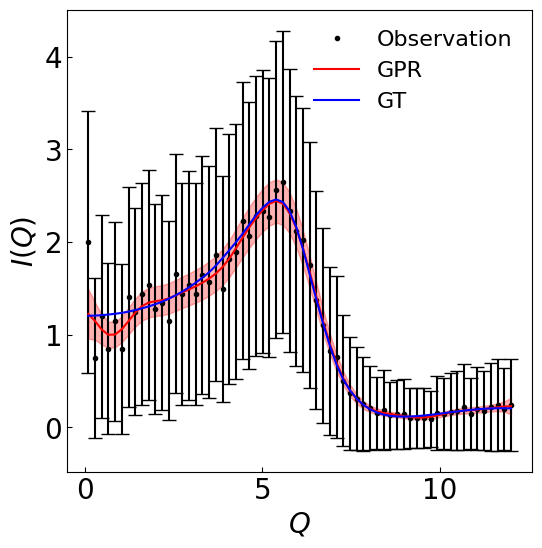

In [234]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]

q_list = []
I_q_gf_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, 2)
    
    I_q_gf_list.append(I_q_gf)
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0),2) # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR


## define kernel function
y_gt = I_q_th
y = I_q_concat-I_q_mean_gf_concat
# y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
# y_err = np.sqrt(1/np.maximum(n_pixels_q_concat,np.ones_like(q)))
y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))
q_x = q_concat
q_s = q

lmbda = 1
sigma = 1
def f_K_rbf(q1, q2, lmbda):
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)
    return K

# f_q = lambda q: np.log(q)
f_q = lambda q: q
K_sigma = np.diag(sigma**2*(y_err**2))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + I_q_gf_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + I_q_gf_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_s, mu_s + I_q_mean_gf, '-r', label='GPR')
ax.fill_between(q_s, mu_s - var_s + I_q_mean_gf, mu_s + var_s + I_q_mean_gf, color='r', alpha=0.3)

ax.plot(q, y_gt , '-b', label='GT')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 3])

ax.legend(frameon=False, fontsize=16)

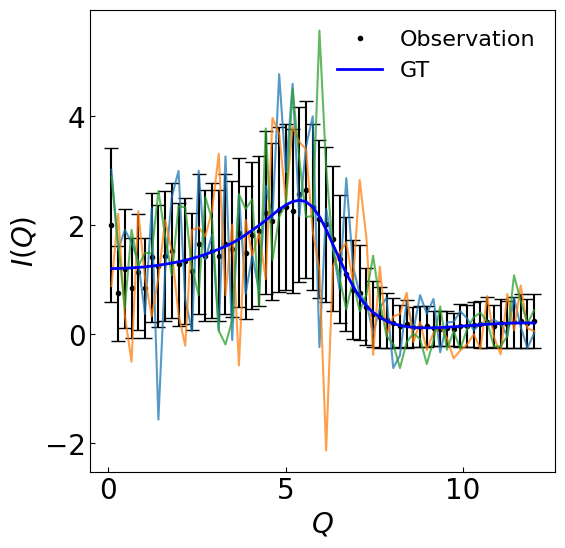

In [252]:
# sample from noisy data
n_curves = 3
I_q_samples = [np.random.normal(loc=I_q, scale=I_err_q) for _ in range(n_curves)]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + I_q_gf_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + I_q_gf_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)

for i, I_q_sample in enumerate(I_q_samples):
    ax.plot(q_x, I_q_samples[i], '-', alpha=0.75)

ax.plot(q, y_gt , '-b', label='GT', lw=2)

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 3])

ax.legend(frameon=False, fontsize=16)